# Detección de manos

MediaPipe incluye un modelo para la predicción del movimiento y articulación de las manos. Este modelo puede ser utilizado para implementar distintos niveles de interacción a través de una cámara.

El modelo de inferencia detecta 21 marcadores de la mano a través de un pipelines con múltiples modelos trabajando de manera conjunta.
Primero se cuenta con un detector de palmas sobre toda la imagen, posteriormente, un modelo de predicción de marcadores procesa la región con la palma. La estrategia es similar a la detección de marcadores faciales observada anteriormente.

 - **Detección de palmas**: se basa en una red de detección SSD optimizada. El modelo es capaz de detectar palmas incluso en distintos niveles de oclusión.
 - **Detección de marcadores**: Se utiliza un modelo de regresión que predice la localización de 21 marcadores de una mano. Se utilizan los siguientes marcadores:

 ![marcadores](hand_landmarks.png)

In [1]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 8]    # incrementar tamaño de plots

MODEL_PATH = "models/hand_landmarker.task"
base_options = python.BaseOptions(model_asset_path=MODEL_PATH)
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

2023-07-21 20:54:53.804701: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 20:54:53.827585: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 20:54:53.828008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 20:54:54.347788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [2]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

In [3]:
def display_color_row(*imgs):
    for i, img in enumerate(imgs):
        print(type(img), img.dtype, img[0,0])
        plt.subplot(1, len(imgs), i + 1)
        plt.imshow(img)
        plt.title(f"{i}")
        plt.xticks([])
        plt.yticks([])

<class 'numpy.ndarray'> uint8 [255 255 255]
<class 'numpy.ndarray'> uint8 [255 255 255]


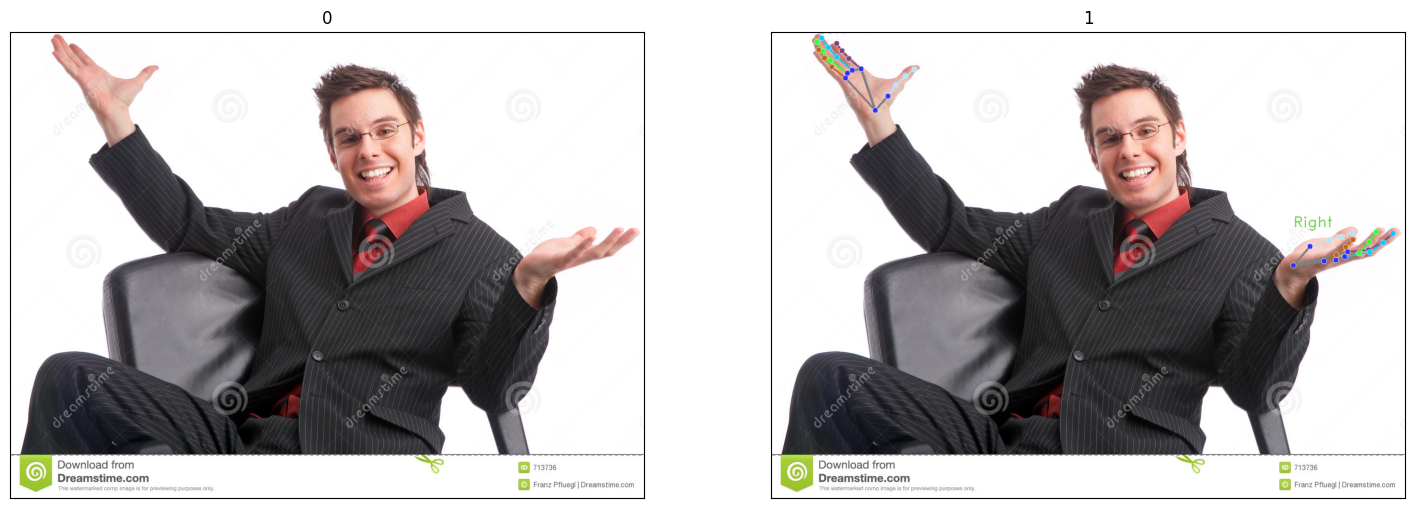

In [7]:
image = mp.Image.create_from_file("person.jpg")

detection_result = detector.detect(image)

annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)

display_color_row(image.numpy_view(), annotated_image)